# Import Necessary Libraries

In [1]:
!pip install optuna
!pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 4.1 MB/s eta 0:00:00


# IMPORT LIBRARIES

In [2]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import optuna
import tensorflow as tf

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.backend import clear_session

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Dense,Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Import Data

In [3]:


file_id = "10gQw4KOyZCfvtKHvEiiTVgmgX1e1UuNc"
csv_url = f"https://drive.google.com/uc?id={file_id}"

# Read the Google Drive file as CSV
df = pd.read_csv(csv_url)

# Backup original DataFrame
df_backup = df.copy()

# Set Date as the index (ensure column name matches your file)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Display first few tourism demand
df.head()

# Backup
df_backup = df.copy()


In [4]:
df.head()

,Total Tourist Arrivals,Sri Lanka Hotels,Sri Lanka Flights,Sri Lanka Visa
Date,,,,
2006-01-01,52103,49,29,0
2006-02-01,52687,41,20,0
2006-03-01,54746,35,20,47
2006-04-01,49776,38,20,0
2006-05-01,43825,34,16,0


In [5]:
df.columns.to_list()

['Total Tourist Arrivals',
 'Sri Lanka Hotels',
 'Sri Lanka Flights',
 'Sri Lanka Visa']

# Pre Processing

In [6]:
# Target
y = df['Total Tourist Arrivals']

# Create lag features
X = pd.concat(
    [y.shift(lag).rename(f"Total Tourist Arrivals(t-{lag})") for lag in range(1, 13)],
    axis=1
)

# Combine and drop NA rows
df = pd.concat([y, X], axis=1).dropna()

# Add month
df["month"] = df.index.month_name()

# One-hot encode month
df = pd.get_dummies(df, columns=["month"], prefix="month")



In [7]:
df.columns.to_list()

['Total Tourist Arrivals',
 'Total Tourist Arrivals(t-1)',
 'Total Tourist Arrivals(t-2)',
 'Total Tourist Arrivals(t-3)',
 'Total Tourist Arrivals(t-4)',
 'Total Tourist Arrivals(t-5)',
 'Total Tourist Arrivals(t-6)',
 'Total Tourist Arrivals(t-7)',
 'Total Tourist Arrivals(t-8)',
 'Total Tourist Arrivals(t-9)',
 'Total Tourist Arrivals(t-10)',
 'Total Tourist Arrivals(t-11)',
 'Total Tourist Arrivals(t-12)',
 'month_April',
 'month_August',
 'month_December',
 'month_February',
 'month_January',
 'month_July',
 'month_June',
 'month_March',
 'month_May',
 'month_November',
 'month_October',
 'month_September']

# Train Test Split

In [8]:
target = "Total Tourist Arrivals"

# Ensure chronological order
df = df.sort_index()   # index should be datetime

# Define forecast horizon
forecast_horizon = 12  # last 12 months

# Split data
train = df.iloc[:-forecast_horizon]
test  = df.iloc[-forecast_horizon:]

# Separate features and target
X_train = train.drop(columns=[target])
y_train = train[target]

X_test = test.drop(columns=[target])
y_test = test[target]

print(f"Train size: {len(train)}")
print(f"Test size (last 12 months): {len(test)}")



Train size: 213
Test size (last 12 months): 12


# Moving Window

In [11]:
# MOVING WINDOW APPROACH
tscv = TimeSeriesSplit(
    n_splits=5
)

# XGB Feature Selection

In [12]:
# XGBOOST

# -----------------------------
# objective
# -----------------------------
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42
    }

    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, y_t = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_v, y_v = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_t, y_t)

        pred = model.predict(X_v)
        fold_scores.append(mean_squared_error(y_v, pred))

    return np.mean(fold_scores)
# -----------------------------
# Run optimization
# -----------------------------
study_xgboost = optuna.create_study(direction="minimize",  sampler=optuna.samplers.TPESampler(seed=42))
study_xgboost.optimize(objective, n_trials=100)
best_params_xgboost = study_xgboost.best_params

# -----------------------------
# Fit XGBOOST
# -----------------------------
xgb_model = XGBRegressor(**best_params_xgboost, random_state=42)
xgb_model.fit(X_train, y_train)


# Metrics
# -----------------------------
# TRAIN PREDICTIONS & METRICS
# -----------------------------
train_pred = xgb_model.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("==== TRAIN METRICS ====")
print("Train MSE :", train_mse)
print("Train RMSE:", train_rmse)
print("Train MAE :", train_mae)
print("Train MAPE:", train_mape)
print("Train R²  :", train_r2)

# -----------------------------
# TEST PREDICTIONS & METRICS
# -----------------------------
test_pred = xgb_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== TEST METRICS ====")
print("Test MSE :", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE :", test_mae)
print("Test MAPE:", test_mape)
print("Test R²  :", test_r2)

[I 2026-02-01 08:10:51,999] A new study created in memory with name: no-name-cc6dd8c7-9b19-482f-a0f9-2455d4938c8b
[I 2026-02-01 08:10:56,523] Trial 0 finished with value: 2591511078.4 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 2591511078.4.
[I 2026-02-01 08:10:56,879] Trial 1 finished with value: 2724025817.6 and parameters: {'n_estimators': 162, 'max_depth': 3, 'learning_rate': 0.2611910822747312, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181}. Best is trial 0 with value: 2591511078.4.
[I 2026-02-01 08:10:57,415] Trial 2 finished with value: 2510442905.6 and parameters: {'n_estimators': 108, 'max_depth': 10, 'learning_rate': 0.2514083658321223, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402}. Best is trial 2 with value: 2510442905.6.
[I 2026-02-01 08:10:57,959] Trial 3 finished with va

==== TRAIN METRICS ====
Train MSE : 0.00014109718904364854
Train RMSE: 0.011878433779065679
Train MAE : 0.008755913004279137
Train MAPE: 235927830528.0
Train R²  : 1.0

==== TEST METRICS ====
Test MSE : 873355520.0
Test RMSE: 29552.58905747515
Test MAE : 25662.390625
Test MAPE: 0.13975001871585846
Test R²  : 0.5168433785438538


### Feature Importance Plot

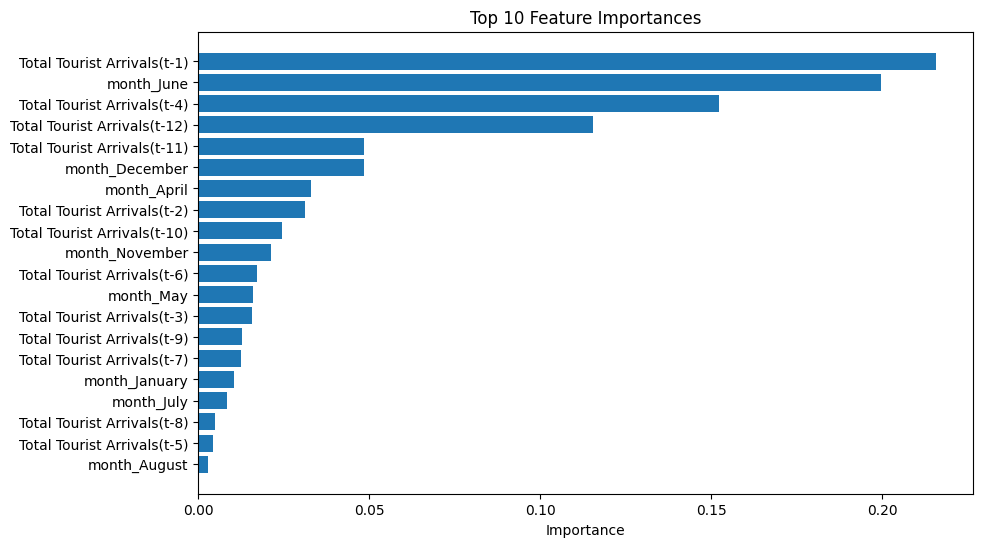

In [13]:
# IMPORTANCE GRAPH
model = xgb_model

# Extract feature importances
importances = model.feature_importances_
feature_names = X_train.columns

# Convert to DataFrame
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})


# Sort & select top 10
top20 = imp_df.sort_values(by="importance", ascending=False).head(20)


# Plot
plt.figure(figsize=(10, 6))
plt.barh(top20["feature"], top20["importance"])
plt.gca().invert_yaxis()  # highest at top
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances")
plt.show()

## Best Elbow

In [14]:
import numpy as np

elbow_points = np.array([1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 15, 16, 17, 19,20])

# Compute differences
diff = np.diff(elbow_points)

# Largest jump → elbow
elbow_index = np.argmax(diff)
best_elbow_point = elbow_points[elbow_index]

print("Best elbow point:", best_elbow_point)

Best elbow point: 10


[I 2026-02-01 08:14:52,835] A new study created in memory with name: no-name-a390cca9-bbde-45b2-b341-1800e6a7e651



========== TUNING FOR TOP 1 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:14:54,072] Trial 0 finished with value: 1623658214.4 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1623658214.4.
[I 2026-02-01 08:14:54,751] Trial 1 finished with value: 1592172710.4 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1592172710.4.
[I 2026-02-01 08:14:55,353] Trial 2 finished with value: 1806033817.6 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:15:43,826] A new study created in memory with name: no-name-eec347e3-3a43-4ea5-9270-9d6120a47602


[I 2026-02-01 08:15:43,653] Trial 49 finished with value: 1459242048.0 and parameters: {'n_estimators': 1331, 'max_depth': 2, 'learning_rate': 0.02214199246296342, 'subsample': 0.9546698281547141, 'colsample_bytree': 0.6521322951331675, 'gamma': 3.1956721475755776, 'min_child_weight': 2, 'reg_alpha': 3.626610750202503, 'reg_lambda': 3.151440165981206}. Best is trial 32 with value: 1440182464.0.
Best Parameters: {'n_estimators': 1410, 'max_depth': 2, 'learning_rate': 0.014976321003720549, 'subsample': 0.8329137480561918, 'colsample_bytree': 0.6977962194283583, 'gamma': 3.8789942948647056, 'min_child_weight': 1, 'reg_alpha': 3.5670693583454045, 'reg_lambda': 3.1145833348803063}

========== TUNING FOR TOP 2 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:15:44,689] Trial 0 finished with value: 1641190323.2 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 1641190323.2.
[I 2026-02-01 08:15:45,323] Trial 1 finished with value: 1549021824.0 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1549021824.0.
[I 2026-02-01 08:15:45,837] Trial 2 finished with value: 1739847155.2 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:16:28,988] A new study created in memory with name: no-name-e226e111-e359-435b-8bb5-97c4a92d1c4b


[I 2026-02-01 08:16:28,818] Trial 49 finished with value: 1439493043.2 and parameters: {'n_estimators': 1202, 'max_depth': 3, 'learning_rate': 0.015729301338171763, 'subsample': 0.906832413297983, 'colsample_bytree': 0.9836439445610162, 'gamma': 4.805945231535325, 'min_child_weight': 2, 'reg_alpha': 2.931438617702547, 'reg_lambda': 4.082952779207885}. Best is trial 44 with value: 1426476083.2.
Best Parameters: {'n_estimators': 1266, 'max_depth': 3, 'learning_rate': 0.01681110566525069, 'subsample': 0.9011797492479844, 'colsample_bytree': 0.9237792987660207, 'gamma': 3.4301327759265177, 'min_child_weight': 1, 'reg_alpha': 2.0806825158535323, 'reg_lambda': 3.285717327930765}

========== TUNING FOR TOP 3 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:16:30,615] Trial 0 finished with value: 2113716326.4 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2113716326.4.
[I 2026-02-01 08:16:31,342] Trial 1 finished with value: 1596502809.6 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1596502809.6.
[I 2026-02-01 08:16:32,011] Trial 2 finished with value: 2266839308.8 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:17:16,806] A new study created in memory with name: no-name-e4c3b0fb-3864-48ee-89f8-8fff435e7af0


[I 2026-02-01 08:17:16,649] Trial 49 finished with value: 2014219648.0 and parameters: {'n_estimators': 1020, 'max_depth': 3, 'learning_rate': 0.12728415905192916, 'subsample': 0.6310439801198263, 'colsample_bytree': 0.6175438062866188, 'gamma': 1.87068037458945, 'min_child_weight': 4, 'reg_alpha': 3.189380851107135, 'reg_lambda': 3.875368534349313}. Best is trial 39 with value: 1588770611.2.
Best Parameters: {'n_estimators': 1153, 'max_depth': 2, 'learning_rate': 0.12242258665764237, 'subsample': 0.6914839493539051, 'colsample_bytree': 0.6388303087511908, 'gamma': 1.6582846824981385, 'min_child_weight': 2, 'reg_alpha': 2.8124098530024213, 'reg_lambda': 4.009523302617653}

========== TUNING FOR TOP 4 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:17:17,922] Trial 0 finished with value: 2197345600.0 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2197345600.0.
[I 2026-02-01 08:17:18,708] Trial 1 finished with value: 1974804185.6 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1974804185.6.
[I 2026-02-01 08:17:19,404] Trial 2 finished with value: 2189893568.0 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:18:23,608] A new study created in memory with name: no-name-4dfa194e-d0cb-46ad-bce8-491a0b3e5425



========== TUNING FOR TOP 6 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:18:24,779] Trial 0 finished with value: 2357767980.8 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2357767980.8.
[I 2026-02-01 08:18:25,635] Trial 1 finished with value: 2416292403.2 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 2357767980.8.
[I 2026-02-01 08:18:26,421] Trial 2 finished with value: 2180076364.8 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:19:13,104] A new study created in memory with name: no-name-ee0e4a44-b059-4380-bf87-17432eb8390b


[I 2026-02-01 08:19:12,988] Trial 49 finished with value: 2250543296.0 and parameters: {'n_estimators': 707, 'max_depth': 6, 'learning_rate': 0.08500611152422978, 'subsample': 0.7378916205891393, 'colsample_bytree': 0.8409458535271649, 'gamma': 2.2754961301667667, 'min_child_weight': 5, 'reg_alpha': 4.197589285502258, 'reg_lambda': 0.6089266475347761}. Best is trial 4 with value: 2130849113.6.
Best Parameters: {'n_estimators': 665, 'max_depth': 2, 'learning_rate': 0.1024932221692416, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'gamma': 2.475884550556351, 'min_child_weight': 1, 'reg_alpha': 4.546602010393911, 'reg_lambda': 1.2938999080000846}

========== TUNING FOR TOP 7 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:19:14,314] Trial 0 finished with value: 2467346752.0 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2467346752.0.
[I 2026-02-01 08:19:15,132] Trial 1 finished with value: 1995067584.0 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1995067584.0.
[I 2026-02-01 08:19:15,957] Trial 2 finished with value: 2430661158.4 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:20:10,369] A new study created in memory with name: no-name-11cc4112-e98e-42d8-9d29-3cdd081e5cf5


[I 2026-02-01 08:20:10,176] Trial 49 finished with value: 2297417164.8 and parameters: {'n_estimators': 1262, 'max_depth': 4, 'learning_rate': 0.17604217676187747, 'subsample': 0.7369098750187555, 'colsample_bytree': 0.6768556162439469, 'gamma': 3.2274486709678145, 'min_child_weight': 4, 'reg_alpha': 1.7802156754787462, 'reg_lambda': 2.679946255694824}. Best is trial 25 with value: 1926244070.4.
Best Parameters: {'n_estimators': 935, 'max_depth': 2, 'learning_rate': 0.284171408901052, 'subsample': 0.969598475955309, 'colsample_bytree': 0.7954412116122239, 'gamma': 4.97334082403923, 'min_child_weight': 4, 'reg_alpha': 1.9260412067470132, 'reg_lambda': 2.2063729014863096}

========== TUNING FOR TOP 8 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:20:11,656] Trial 0 finished with value: 2433984204.8 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2433984204.8.
[I 2026-02-01 08:20:12,515] Trial 1 finished with value: 2711105728.0 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 2433984204.8.
[I 2026-02-01 08:20:13,343] Trial 2 finished with value: 2351004531.2 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:21:47,266] A new study created in memory with name: no-name-e4d2d06c-ca2e-4c25-bf8f-d461d660686f



========== TUNING FOR TOP 9 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:21:48,591] Trial 0 finished with value: 2313271616.0 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2313271616.0.
[I 2026-02-01 08:21:49,480] Trial 1 finished with value: 2254308915.2 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 2254308915.2.
[I 2026-02-01 08:21:50,373] Trial 2 finished with value: 2270893734.4 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:23:13,083] A new study created in memory with name: no-name-5e05d9b2-75a2-405f-9a79-cda3bb0ae358



========== TUNING FOR TOP 10 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:23:14,491] Trial 0 finished with value: 2113658585.6 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2113658585.6.
[I 2026-02-01 08:23:15,405] Trial 1 finished with value: 1988771942.4 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 1988771942.4.
[I 2026-02-01 08:23:16,343] Trial 2 finished with value: 2459935142.4 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:24:07,978] A new study created in memory with name: no-name-82e858b6-12c1-41a3-a8a3-941292b1f3e4



========== TUNING FOR TOP 13 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:24:09,702] Trial 0 finished with value: 2295653580.8 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2295653580.8.
[I 2026-02-01 08:24:11,954] Trial 1 finished with value: 2069763276.8 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 2069763276.8.
[I 2026-02-01 08:24:12,987] Trial 2 finished with value: 2445155686.4 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:25:30,792] A new study created in memory with name: no-name-4c2c13c7-d5ef-473b-b54f-cb8a2c17eccb



========== TUNING FOR TOP 15 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:25:32,434] Trial 0 finished with value: 2209747520.0 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2209747520.0.
[I 2026-02-01 08:25:33,514] Trial 1 finished with value: 2466309363.2 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 2209747520.0.
[I 2026-02-01 08:25:34,647] Trial 2 finished with value: 2086334080.0 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:26:55,976] A new study created in memory with name: no-name-e53d3a9a-b2ba-4306-a18a-34b8ea9b3f59



========== TUNING FOR TOP 16 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:26:57,673] Trial 0 finished with value: 2643354457.6 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2643354457.6.
[I 2026-02-01 08:26:58,765] Trial 1 finished with value: 2773288985.6 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 2643354457.6.
[I 2026-02-01 08:26:59,905] Trial 2 finished with value: 2343520204.8 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:28:14,591] A new study created in memory with name: no-name-fe4b07c2-a595-49b9-a281-83167bf47dda



========== TUNING FOR TOP 17 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:28:17,612] Trial 0 finished with value: 2288340678.4 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2288340678.4.
[I 2026-02-01 08:28:18,738] Trial 1 finished with value: 2298673049.6 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 2288340678.4.
[I 2026-02-01 08:28:19,880] Trial 2 finished with value: 2317597657.6 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:29:24,198] A new study created in memory with name: no-name-569d958f-8292-4242-a68e-7ed9f20c9d98



========== TUNING FOR TOP 19 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:29:26,060] Trial 0 finished with value: 2318342054.4 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2318342054.4.
[I 2026-02-01 08:29:27,297] Trial 1 finished with value: 2200700876.8 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 2200700876.8.
[I 2026-02-01 08:29:30,097] Trial 2 finished with value: 2320824998.4 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

[I 2026-02-01 08:30:55,532] A new study created in memory with name: no-name-d01fff38-b6c8-45e8-afbf-7be159920b21



========== TUNING FOR TOP 20 FEATURES ==========


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-01 08:30:57,517] Trial 0 finished with value: 2344891968.0 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.7799726016810132, 'min_child_weight': 1, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 2344891968.0.
[I 2026-02-01 08:30:58,768] Trial 1 finished with value: 2480094899.2 and parameters: {'n_estimators': 1150, 'max_depth': 2, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'gamma': 0.9091248360355031, 'min_child_weight': 2, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 0 with value: 2344891968.0.
[I 2026-02-01 08:31:00,023] Trial 2 finished with value: 2320165862.4 and parameters: {'n_estimators': 818, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'subsample': 0.6557975442608167, 'colsample_by

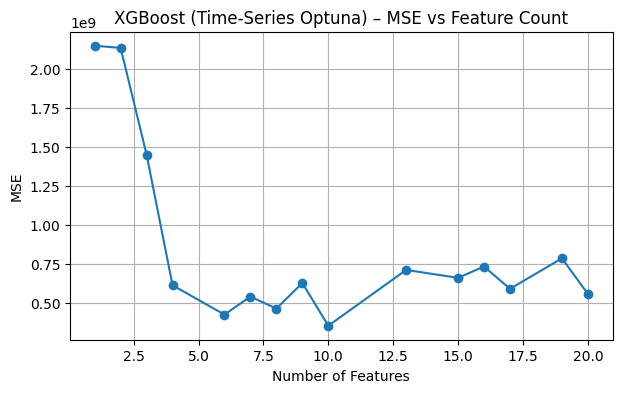

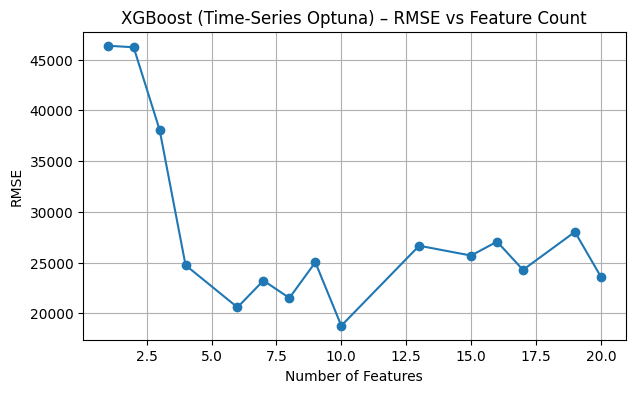

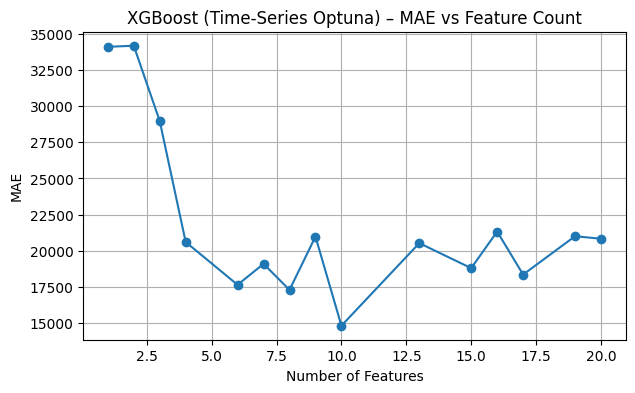

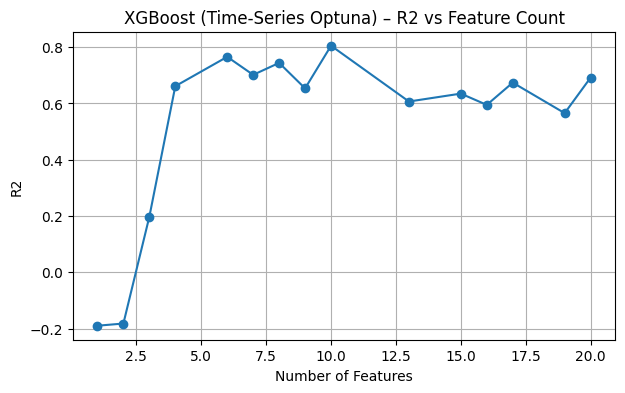

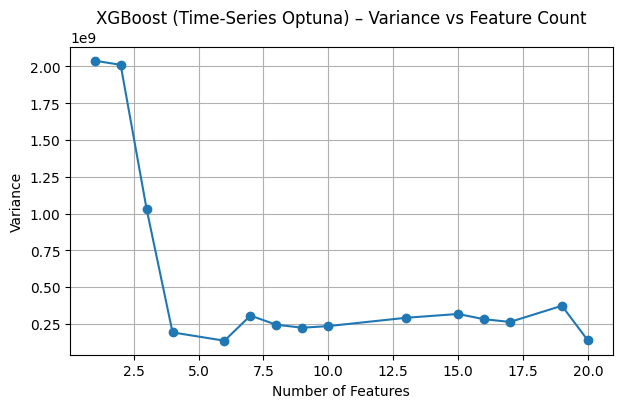

In [15]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.model_selection import TimeSeriesSplit

# --------------------------------------------------------------
# STEP 1 — Optuna Objective (TIME SERIES SAFE)
# --------------------------------------------------------------

def objective(trial):

    params = {
           "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    tscv = TimeSeriesSplit(n_splits=5)
    rmses = []

    for train_idx, val_idx in tscv.split(X_train_sub):
        X_tr = X_train_sub.iloc[train_idx]
        X_val = X_train_sub.iloc[val_idx]
        y_tr = y_train.iloc[train_idx]
        y_val = y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        rmse = mean_squared_error(y_val, preds)
        rmses.append(rmse)

    return np.mean(rmses)


# --------------------------------------------------------------
# STEP 2 — Loop Through Elbow Points
# --------------------------------------------------------------

results = []

for n in elbow_points:
    print(f"\n========== TUNING FOR TOP {n} FEATURES ==========")

    # ------------------------
    # Select top-N features
    # ------------------------
    top_features = (
        imp_df.sort_values("importance", ascending=False)
              .head(n)["feature"]
              .tolist()
    )

    X_train_sub = X_train[top_features]
    X_test_sub  = X_test[top_features]

    # ------------------------
    # Optuna Study
    # ------------------------
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Best Parameters:", study.best_params)

    # ------------------------
    # Train Final Model
    # (Full training history)
    # ------------------------
    final_model = XGBRegressor(
        **study.best_params,
        objective="reg:squarederror",
        eval_metric="rmse",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )

    final_model.fit(X_train_sub, y_train)

    # ------------------------
    # Test Evaluation
    # ------------------------
    y_pred = final_model.predict(X_test_sub)

    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    var  = np.var(y_test - y_pred)

    results.append([n, mse, rmse, mae, r2, var])


# --------------------------------------------------------------
# STEP 3 — Metric Table
# --------------------------------------------------------------

metric_df = pd.DataFrame(
    results,
    columns=["Features", "MSE", "RMSE", "MAE", "R2", "Variance"]
)

print("\nFINAL METRIC TABLE:")
print(metric_df)


# --------------------------------------------------------------
# STEP 4 — Plot Metrics
# --------------------------------------------------------------

metrics = ["MSE", "RMSE", "MAE", "R2", "Variance"]

for m in metrics:
    plt.figure(figsize=(7, 4))
    plt.plot(metric_df["Features"], metric_df[m], marker="o")
    plt.xlabel("Number of Features")
    plt.ylabel(m)
    plt.title(f"XGBoost (Time-Series Optuna) – {m} vs Feature Count")
    plt.grid(True)
    plt.show()



# Selected Features

In [19]:
selected_features = top20['feature'][:10].to_list()

In [20]:
selected_features

['Total Tourist Arrivals(t-1)',
 'month_June',
 'Total Tourist Arrivals(t-4)',
 'Total Tourist Arrivals(t-12)',
 'Total Tourist Arrivals(t-11)',
 'month_December',
 'month_April',
 'Total Tourist Arrivals(t-2)',
 'Total Tourist Arrivals(t-10)',
 'month_November']

In [21]:
selected_features = ['Total Tourist Arrivals(t-1)',
 'month_June',
 'Total Tourist Arrivals(t-4)',
 'Total Tourist Arrivals(t-12)',
 'Total Tourist Arrivals(t-11)',
 'month_December',
 'month_April',
 'Total Tourist Arrivals(t-2)',
 'Total Tourist Arrivals(t-10)',
 'month_November']

## New X_Train X_Test

In [22]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# RF

In [23]:
# RANDOM FOREST
# -----------------------------
# Objective
# -----------------------------
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "random_state": 42
    }

    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, y_t = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_v, y_v = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_t, y_t)

        pred = model.predict(X_v)
        fold_scores.append(mean_squared_error(y_v, pred))

    return np.mean(fold_scores)
# -----------------------------
# Run optimization
# -----------------------------
study_rf = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=100)

best_params_rf = study_rf.best_params

# -----------------------------
# FIT RANDOM FOREST
# -----------------------------
rf_model = RandomForestRegressor(**best_params_rf, random_state=42)
rf_model.fit(X_train, y_train)

pred_xgb = rf_model.predict(X_test)


# -----------------------------
# TRAIN PREDICTIONS & METRICS
# -----------------------------
train_pred = rf_model.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("==== TRAIN METRICS ====")
print("Train MSE :", train_mse)
print("Train RMSE:", train_rmse)
print("Train MAE :", train_mae)
print("Train MAPE:", train_mape)
print("Train R²  :", train_r2)

# -----------------------------
# TEST PREDICTIONS & METRICS
# -----------------------------
test_pred = rf_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== TEST METRICS ====")
print("Test MSE :", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE :", test_mae)
print("Test MAPE:", test_mape)
print("Test R²  :", test_r2)

[I 2026-02-01 08:39:02,053] A new study created in memory with name: no-name-69fd1ca3-02ea-4d83-9323-9e3783429ff3
[I 2026-02-01 08:39:03,565] Trial 0 finished with value: 2517294111.3975215 and parameters: {'n_estimators': 250, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 2517294111.3975215.
[I 2026-02-01 08:39:04,330] Trial 1 finished with value: 2591333558.474917 and parameters: {'n_estimators': 123, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 2517294111.3975215.
[I 2026-02-01 08:39:06,965] Trial 2 finished with value: 2086067429.8071456 and parameters: {'n_estimators': 433, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 2086067429.8071456.
[I 2026-02-01 08:39:08,637] Trial 3 finished with value: 2324455482.157382 and parameters: {'n_estimators': 273, 'max_depth': 8, 'min

==== TRAIN METRICS ====
Train MSE : 75059518.84270266
Train RMSE: 8663.689678347364
Train MAE : 5720.527459945941
Train MAPE: 1.9550064651578028e+18
Train R²  : 0.9830600595743857

==== TEST METRICS ====
Test MSE : 317532244.14304024
Test RMSE: 17819.434450706907
Test MAE : 15731.28478605057
Test MAPE: 0.08238546105445281
Test R²  : 0.8243352303454936


# XGB

In [24]:
# XGBOOST

# -----------------------------
# objective
# -----------------------------
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42
    }

    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_t, y_t = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_v, y_v = X_train.iloc[val_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_t, y_t)

        pred = model.predict(X_v)
        fold_scores.append(mean_squared_error(y_v, pred))

    return np.mean(fold_scores)
# -----------------------------
# Run optimization
# -----------------------------
study_xgboost = optuna.create_study(direction="minimize",  sampler=optuna.samplers.TPESampler(seed=42))
study_xgboost.optimize(objective, n_trials=100)
best_params_xgboost = study_xgboost.best_params

# -----------------------------
# Fit XGBOOST
# -----------------------------
xgb_model = XGBRegressor(**best_params_xgboost, random_state=42)
xgb_model.fit(X_train, y_train)

pred_xgb = xgb_model.predict(X_test)

# Metrics
# -----------------------------
# TRAIN PREDICTIONS & METRICS
# -----------------------------
train_pred = xgb_model.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("==== TRAIN METRICS ====")
print("Train MSE :", train_mse)
print("Train RMSE:", train_rmse)
print("Train MAE :", train_mae)
print("Train MAPE:", train_mape)
print("Train R²  :", train_r2)

# -----------------------------
# TEST PREDICTIONS & METRICS
# -----------------------------
test_pred = xgb_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== TEST METRICS ====")
print("Test MSE :", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE :", test_mae)
print("Test MAPE:", test_mape)
print("Test R²  :", test_r2)

[I 2026-02-01 08:43:11,677] A new study created in memory with name: no-name-8dde3ff9-b632-42f4-98d8-7dd6b3871622
[I 2026-02-01 08:43:12,478] Trial 0 finished with value: 1811229683.2 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746}. Best is trial 0 with value: 1811229683.2.
[I 2026-02-01 08:43:12,696] Trial 1 finished with value: 2320711001.6 and parameters: {'n_estimators': 162, 'max_depth': 3, 'learning_rate': 0.2611910822747312, 'subsample': 0.8404460046972835, 'colsample_bytree': 0.8832290311184181}. Best is trial 0 with value: 1811229683.2.
[I 2026-02-01 08:43:13,053] Trial 2 finished with value: 1978093427.2 and parameters: {'n_estimators': 108, 'max_depth': 10, 'learning_rate': 0.2514083658321223, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402}. Best is trial 0 with value: 1811229683.2.
[I 2026-02-01 08:43:13,387] Trial 3 finished with va

==== TRAIN METRICS ====
Train MSE : 0.0015910170041024685
Train RMSE: 0.039887554501403924
Train MAE : 0.028834030032157898
Train MAPE: 1845767569408.0
Train R²  : 1.0

==== TEST METRICS ====
Test MSE : 332637984.0
Test RMSE: 18238.36571625868
Test MAE : 16228.0546875
Test MAPE: 0.08890917152166367
Test R²  : 0.8159784078598022


#  Scale X_train, X_test

In [25]:
month_cols = [col for col in X_train.columns if 'month_' in col]
num_cols = [col for col in X_train.columns if col not in month_cols]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# scale numeric features
X_train_num_scaled = scaler_X.fit_transform(X_train[num_cols])
X_test_num_scaled = scaler_X.transform(X_test[num_cols])

y_train_scaled = pd.Series(
    scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten(),
    index=y_train.index
)

y_test_scaled = pd.Series(
    scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).flatten(),
    index=y_test.index
)

# add the categorical columns
# Rebuild X_train and X_test as DataFrames
X_train_scaled = pd.DataFrame(
    np.hstack([X_train_num_scaled, X_train[month_cols].values]),
    index=X_train.index,
    columns=num_cols + month_cols
)

X_test_scaled = pd.DataFrame(
    np.hstack([X_test_num_scaled, X_test[month_cols].values]),
    index=X_test.index,
    columns=num_cols + month_cols
)


# SVR

In [26]:

# =============================
# SVR Objective Function
# =============================
def objective_svr(trial):

    params = {
        "C": trial.suggest_float("C", 0.1, 100.0, log=True),
        "epsilon": trial.suggest_float("epsilon", 0.001, 1.0, log=True),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "kernel": trial.suggest_categorical("kernel", ["rbf", "poly", "sigmoid"])
    }

    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train_scaled):

        X_t = X_train_scaled.iloc[train_idx]
        X_v = X_train_scaled.iloc[val_idx]

        y_t = y_train_scaled.iloc[train_idx]
        y_v = y_train_scaled.iloc[val_idx]

        model = SVR(**params)
        model.fit(X_t, y_t)

        preds = model.predict(X_v)
        fold_scores.append(mean_squared_error(y_v, preds))

    return np.mean(fold_scores)



# =============================
# RUN OPTUNA
# =============================
study_svr = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_svr.optimize(objective_svr, n_trials=100)
best_params_svr = study_svr.best_params



# =============================
# FIT FINAL SVR MODEL
# =============================
svr_model = SVR(**best_params_svr)
svr_model.fit(X_train_scaled, y_train_scaled)

# Train predictions
train_pred_scaled = svr_model.predict(X_train_scaled)
train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()

# Test predictions
test_pred_scaled = svr_model.predict(X_test_scaled)
test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()


print("==== SVR TRAIN METRICS ====")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Train MAE :", mean_absolute_error(y_train, train_pred))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_pred))
print("Train R²  :", r2_score(y_train, train_pred))

print("\n==== SVR TEST METRICS ====")
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))
print("Test MAE :", mean_absolute_error(y_test, test_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, test_pred))
print("Test R²  :", r2_score(y_test, test_pred))

[I 2026-02-01 08:44:25,107] A new study created in memory with name: no-name-2c8a83f8-df99-4855-9ee9-764ee2b6a4f8
[I 2026-02-01 08:44:25,128] Trial 0 finished with value: 0.920685717978319 and parameters: {'C': 1.3292918943162166, 'epsilon': 0.711447600934342, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 0 with value: 0.920685717978319.
[I 2026-02-01 08:44:25,168] Trial 1 finished with value: 0.6872051579897687 and parameters: {'C': 39.67605077052987, 'epsilon': 0.06358358856676251, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 1 with value: 0.6872051579897687.
[I 2026-02-01 08:44:25,195] Trial 2 finished with value: 0.5015607254454915 and parameters: {'C': 0.3511356313970407, 'epsilon': 0.0035498788321965025, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 2 with value: 0.5015607254454915.
[I 2026-02-01 08:44:25,216] Trial 3 finished with value: 0.53722912506083 and parameters: {'C': 0.262108787826544, 'epsilon': 0.007523742884534853, 'gamma': 'auto', 'kernel': 'rbf'}. B

==== SVR TRAIN METRICS ====
Train RMSE: 9830.46065094621
Train MAE : 5206.567744658123
Train MAPE: 1.590951786514218e+17
Train R²  : 0.978190091635762

==== SVR TEST METRICS ====
Test RMSE: 16703.844713915947
Test MAE : 13486.421692871425
Test MAPE: 0.0734566604404691
Test R²  : 0.8456417928325042


# ANN

In [27]:

# ANN
# -----------------------------
# Objective Function for Optuna
# -----------------------------
def objective_ann(trial):

    params = {
        "hidden1": trial.suggest_int("hidden1", 8, 128),
        "hidden2": trial.suggest_int("hidden2", 8, 128),
        "lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    }

    fold_scores = []

    for train_idx, val_idx in tscv.split(X_train_scaled):

        X_t = X_train_scaled.iloc[train_idx]
        X_v = X_train_scaled.iloc[val_idx]

        y_t = y_train_scaled.iloc[train_idx]
        y_v = y_train_scaled.iloc[val_idx]

        model = MLPRegressor(
            hidden_layer_sizes=(params["hidden1"], params["hidden2"]),
            learning_rate_init=params["lr"],
            alpha=params["alpha"],
            random_state=42,
            max_iter=500
        )

        model.fit(X_t, y_t)
        preds = model.predict(X_v)

        fold_scores.append(mean_squared_error(y_v, preds))

    return np.mean(fold_scores)



# -----------------------------
# Run Optimization
# -----------------------------
study_ann = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_ann.optimize(objective_ann, n_trials=100)
best_params_ann = study_ann.best_params


# -----------------------------
# FIT ANN
# -----------------------------
ann_model = MLPRegressor(
    hidden_layer_sizes=(
        best_params_ann["hidden1"],
        best_params_ann["hidden2"]
    ),
    learning_rate_init=best_params_ann["lr"],
    alpha=best_params_ann["alpha"],
    random_state=42,
    max_iter=500
)

ann_model.fit(X_train_scaled, y_train_scaled)

# Train predictions
train_pred_scaled = ann_model.predict(X_train_scaled)
train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()

# Test predictions
test_pred_scaled = ann_model.predict(X_test_scaled)
test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

print("==== ANN TRAIN METRICS ====")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Train MAE :", mean_absolute_error(y_train, train_pred))
print("Train MAPE:", mean_absolute_percentage_error(y_train, train_pred))
print("Train R²  :", r2_score(y_train, train_pred))

print("\n==== ANN TEST METRICS ====")
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))
print("Test MAE :", mean_absolute_error(y_test, test_pred))
print("Test MAPE:", mean_absolute_percentage_error(y_test, test_pred))
print("Test R²  :", r2_score(y_test, test_pred))



[I 2026-02-01 08:44:28,609] A new study created in memory with name: no-name-ae27f10f-6c95-4381-ae9c-ade612993ca7
[I 2026-02-01 08:44:31,588] Trial 0 finished with value: 0.34394283493070366 and parameters: {'hidden1': 53, 'hidden2': 123, 'lr': 0.0029106359131330704, 'alpha': 0.0006251373574521745}. Best is trial 0 with value: 0.34394283493070366.
[I 2026-02-01 08:44:33,189] Trial 1 finished with value: 0.36418195956841903 and parameters: {'hidden1': 26, 'hidden2': 26, 'lr': 0.00013066739238053285, 'alpha': 0.003967605077052989}. Best is trial 0 with value: 0.34394283493070366.
[I 2026-02-01 08:44:38,241] Trial 2 finished with value: 0.5566248445606545 and parameters: {'hidden1': 80, 'hidden2': 93, 'lr': 0.00010994335574766199, 'alpha': 0.008123245085588688}. Best is trial 0 with value: 0.34394283493070366.
[I 2026-02-01 08:44:39,150] Trial 3 finished with value: 0.30497511370429176 and parameters: {'hidden1': 108, 'hidden2': 33, 'lr': 0.0002310201887845295, 'alpha': 3.5498788321965036

==== ANN TRAIN METRICS ====
Train RMSE: 9713.872176187318
Train MAE : 6963.307293932966
Train MAPE: 7.304544872043077e+17
Train R²  : 0.9787043514316612

==== ANN TEST METRICS ====
Test RMSE: 14980.833758917523
Test MAE : 11504.960675158332
Test MAPE: 0.06527279283926844
Test R²  : 0.8758436869664898


# LSTM

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import optuna

# -----------------------------
# RESHAPE FOR LSTM
# (timesteps = 1, features = n_features)
# -----------------------------
X_train_lstm = X_train_scaled.values.reshape(
    (X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
)
X_test_lstm = X_test_scaled.values.reshape(
    (X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
)

# -----------------------------
# OPTUNA OBJECTIVE FUNCTION
# -----------------------------
def objective_lstm(trial):

    tf.keras.backend.clear_session()

    n_units = trial.suggest_int("n_units", 1, 64)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13])
    epochs = 60

    fold_losses = []

    for train_idx, val_idx in tscv.split(X_train_lstm):

        X_t, X_v = X_train_lstm[train_idx], X_train_lstm[val_idx]
        y_t, y_v = y_train_scaled.iloc[train_idx], y_train_scaled.iloc[val_idx]

        model = Sequential([
            Input(shape=(X_t.shape[1], X_t.shape[2])),
            LSTM(n_units),
            Dropout(dropout),
            Dense(1)
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss="mse"
        )

        callbacks = [
            EarlyStopping(
                monitor="val_loss",
                patience=10,
                restore_best_weights=True
            )
        ]

        model.fit(
            X_t, y_t,
            validation_data=(X_v, y_v),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=0
        )

        preds = model.predict(X_v, verbose=0)
        fold_losses.append(mean_squared_error(y_v, preds))

    return np.mean(fold_losses)

# -----------------------------
# RUN OPTUNA
# -----------------------------
study_lstm = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_lstm.optimize(objective_lstm, n_trials=20)

best_params_lstm = study_lstm.best_params
print("Best LSTM Params:", best_params_lstm)

# -----------------------------
# FINAL LSTM MODEL
# -----------------------------
tf.keras.backend.clear_session()

lstm_model = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(best_params_lstm["n_units"]),
    Dropout(best_params_lstm["dropout"]),
    Dense(1)
])

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=best_params_lstm["lr"]
    ),
    loss="mse"
)

final_callbacks = [
    EarlyStopping(
        monitor="loss",
        patience=10,
        restore_best_weights=True
    )
]

lstm_model.fit(
    X_train_lstm,
    y_train_scaled,
    epochs=80,
    batch_size=best_params_lstm["batch_size"],
    callbacks=final_callbacks,
    verbose=1
)

# -----------------------------
# PREDICTIONS & INVERSE SCALE
# -----------------------------
train_pred_scaled = lstm_model.predict(X_train_lstm)
test_pred_scaled = lstm_model.predict(X_test_lstm)

train_pred = scaler_y.inverse_transform(train_pred_scaled).ravel()
test_pred = scaler_y.inverse_transform(test_pred_scaled).ravel()

# -----------------------------
# TRAIN METRICS
# -----------------------------
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("\n==== LSTM TRAIN METRICS ====")
print(f"MSE  : {train_mse:.4f}")
print(f"RMSE : {train_rmse:.4f}")
print(f"MAE  : {train_mae:.4f}")
print(f"MAPE : {train_mape:.4f}")
print(f"R²   : {train_r2:.4f}")

# -----------------------------
# TEST METRICS
# -----------------------------
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== LSTM TEST METRICS ====")
print(f"MSE  : {test_mse:.4f}")
print(f"RMSE : {test_rmse:.4f}")
print(f"MAE  : {test_mae:.4f}")
print(f"MAPE : {test_mape:.4f}")
print(f"R²   : {test_r2:.4f}")


[I 2026-02-01 08:45:20,149] A new study created in memory with name: no-name-b29b7c96-fb3e-41f1-bebb-bca330472db9
[I 2026-02-01 08:45:57,468] Trial 0 finished with value: 0.26792334111234745 and parameters: {'n_units': 24, 'dropout': 0.3802857225639665, 'lr': 0.0029106359131330704, 'batch_size': 10}. Best is trial 0 with value: 0.26792334111234745.
[I 2026-02-01 08:46:40,402] Trial 1 finished with value: 0.336525889547785 and parameters: {'n_units': 12, 'dropout': 0.1216968971838151, 'lr': 0.0011207606211860567, 'batch_size': 9}. Best is trial 0 with value: 0.26792334111234745.
[I 2026-02-01 08:47:58,146] Trial 2 finished with value: 0.34357068582869466 and parameters: {'n_units': 39, 'dropout': 0.06820964947491662, 'lr': 0.00013492834268013249, 'batch_size': 3}. Best is trial 0 with value: 0.26792334111234745.
[I 2026-02-01 08:48:43,298] Trial 3 finished with value: 0.2563498513556525 and parameters: {'n_units': 43, 'dropout': 0.12468443043576438, 'lr': 0.001096821720752952, 'batch_si

Best LSTM Params: {'n_units': 35, 'dropout': 0.18799073880112063, 'lr': 0.00871832860200836, 'batch_size': 6}
Epoch 1/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4621
Epoch 2/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1513
Epoch 3/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1546
Epoch 4/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0785
Epoch 5/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0841
Epoch 6/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0969
Epoch 7/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1023
Epoch 8/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0845
Epoch 9/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1222
Epoch 10/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1334
Epoch 11/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0701
Epoch 12/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1179
Epoch 13/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0662
Epoch 14/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s

# GRU

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import optuna

# -----------------------------
# RESHAPE FOR GRU
# -----------------------------
X_train_gru = X_train_scaled.values.reshape(
    (X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
)
X_test_gru = X_test_scaled.values.reshape(
    (X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
)

# -----------------------------
# OPTUNA OBJECTIVE FUNCTION
# -----------------------------
def objective_gru(trial):

    clear_session()

    n_units = trial.suggest_int("n_units", 1, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical(
        "batch_size", [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    )
    epochs = 60

    fold_losses = []

    for train_idx, val_idx in tscv.split(X_train_gru):

        X_t, X_v = X_train_gru[train_idx], X_train_gru[val_idx]
        y_t, y_v = y_train_scaled.iloc[train_idx], y_train_scaled.iloc[val_idx]

        bs = min(batch_size, len(X_t))  # safety only

        model = Sequential([
            Input(shape=(X_t.shape[1], X_t.shape[2])),
            GRU(n_units),
            Dropout(dropout),
            Dense(1)
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=lr,
                clipnorm=1.0
            ),
            loss="mse"
        )

        callbacks = [
            EarlyStopping(
                monitor="val_loss",
                patience=10,
                restore_best_weights=True
            )
        ]

        model.fit(
            X_t,
            y_t,
            validation_data=(X_v, y_v),
            epochs=epochs,
            batch_size=bs,
            callbacks=callbacks,
            verbose=0
        )

        preds = model.predict(X_v, verbose=0).flatten()
        fold_losses.append(mean_squared_error(y_v, preds))

    return np.mean(fold_losses)

# -----------------------------
# RUN OPTUNA
# -----------------------------
study_gru = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study_gru.optimize(objective_gru, n_trials=20)

best_params_gru = study_gru.best_params
print("Best GRU Params:", best_params_gru)

# -----------------------------
# FINAL GRU MODEL
# -----------------------------
clear_session()

gru_model = Sequential([
    Input(shape=(X_train_gru.shape[1], X_train_gru.shape[2])),
    GRU(best_params_gru["n_units"]),
    Dropout(best_params_gru["dropout"]),
    Dense(1)
])

gru_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=best_params_gru["lr"],
        clipnorm=1.0
    ),
    loss="mse"
)

final_callbacks = [
    EarlyStopping(
        monitor="loss",
        patience=10,
        restore_best_weights=True
    )
]

gru_model.fit(
    X_train_gru,
    y_train_scaled,
    epochs=80,
    batch_size=min(best_params_gru["batch_size"], len(X_train_gru)),
    callbacks=final_callbacks,
    verbose=1
)

# -----------------------------
# PREDICTIONS & INVERSE SCALE
# -----------------------------
train_pred_scaled = gru_model.predict(X_train_gru, verbose=0)
test_pred_scaled = gru_model.predict(X_test_gru, verbose=0)

train_pred = scaler_y.inverse_transform(train_pred_scaled).flatten()
test_pred = scaler_y.inverse_transform(test_pred_scaled).flatten()

# -----------------------------
# TRAIN METRICS
# -----------------------------
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("\n==== GRU TRAIN METRICS ====")
print(f"MSE  : {train_mse:.4f}")
print(f"RMSE : {train_rmse:.4f}")
print(f"MAE  : {train_mae:.4f}")
print(f"MAPE : {train_mape:.4f}")
print(f"R²   : {train_r2:.4f}")

# -----------------------------
# TEST METRICS
# -----------------------------
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== GRU TEST METRICS ====")
print(f"MSE  : {test_mse:.4f}")
print(f"RMSE : {test_rmse:.4f}")
print(f"MAE  : {test_mae:.4f}")
print(f"MAPE : {test_mape:.4f}")
print(f"R²   : {test_r2:.4f}")


[I 2026-02-01 08:59:52,435] A new study created in memory with name: no-name-41891a09-f8a7-489f-b64a-4697b30dff22
[I 2026-02-01 09:00:20,395] Trial 0 finished with value: 0.2554942899367062 and parameters: {'n_units': 48, 'dropout': 0.3802857225639665, 'lr': 0.0029106359131330704, 'batch_size': 10}. Best is trial 0 with value: 0.2554942899367062.
[I 2026-02-01 09:00:56,295] Trial 1 finished with value: 0.3219457376793538 and parameters: {'n_units': 24, 'dropout': 0.1216968971838151, 'lr': 0.0011207606211860567, 'batch_size': 9}. Best is trial 0 with value: 0.2554942899367062.
[I 2026-02-01 09:02:03,118] Trial 2 finished with value: 0.2662913700746608 and parameters: {'n_units': 78, 'dropout': 0.06820964947491662, 'lr': 0.00013492834268013249, 'batch_size': 3}. Best is trial 0 with value: 0.2554942899367062.
[I 2026-02-01 09:02:43,171] Trial 3 finished with value: 0.23481013154748473 and parameters: {'n_units': 85, 'dropout': 0.12468443043576438, 'lr': 0.001096821720752952, 'batch_size'

Best GRU Params: {'n_units': 85, 'dropout': 0.12468443043576438, 'lr': 0.001096821720752952, 'batch_size': 4}
Epoch 1/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8231
Epoch 2/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2074
Epoch 3/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1521
Epoch 4/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1163
Epoch 5/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0997
Epoch 6/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0986
Epoch 7/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1649
Epoch 8/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1175
Epoch 9/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1182
Epoch 10/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0961
Epoch 11/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0924
Epoch 12/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0914
Epoch 13/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0971
Epoch 14/80
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s

# CNN

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import optuna

# -----------------------------
# RESHAPE FOR CNN
# (timesteps = 1, features = n_features)
# -----------------------------
X_train_cnn = X_train_scaled.values.reshape(
    (X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
)
X_test_cnn = X_test_scaled.values.reshape(
    (X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
)

# -----------------------------
# OPTUNA OBJECTIVE FUNCTION
# -----------------------------
def objective_cnn(trial):
    tf.keras.backend.clear_session()

    n_filters = trial.suggest_int("n_filters", 1, 128)
    kernel_size = trial.suggest_int("kernel_size", 1, 1)  # single timestep
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
    epochs = 60

    fold_losses = []

    for train_idx, val_idx in tscv.split(X_train_scaled):
        tf.keras.backend.clear_session()

        X_t, X_v = X_train_cnn[train_idx], X_train_cnn[val_idx]
        y_t, y_v = y_train_scaled.iloc[train_idx], y_train_scaled.iloc[val_idx]

        # Ensure batch size <= fold size
        bs = min(batch_size, len(X_t))

        model = Sequential([
            Input(shape=(X_t.shape[1], X_t.shape[2])),
            Conv1D(filters=n_filters, kernel_size=kernel_size, activation="relu"),
            Dropout(dropout),
            Flatten(),
            Dense(1)
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")

        callbacks = [
            EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        ]

        model.fit(
            X_t, y_t,
            validation_data=(X_v, y_v),
            epochs=epochs,
            batch_size=bs,
            verbose=0,
            callbacks=callbacks
        )

        preds = model.predict(X_v, verbose=0).flatten()
        fold_losses.append(mean_squared_error(y_v, preds))

    return np.mean(fold_losses)

# -----------------------------
# RUN OPTUNA
# -----------------------------
study_cnn = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study_cnn.optimize(objective_cnn, n_trials=20)

best_params_cnn = study_cnn.best_params
print("Best CNN Params:", best_params_cnn)

tf.keras.backend.clear_session()

# -----------------------------
# FIT FINAL CNN
# -----------------------------
cnn_model = Sequential([
    Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    Conv1D(filters=best_params_cnn["n_filters"],
           kernel_size=best_params_cnn["kernel_size"],
           activation="relu"),
    Dropout(best_params_cnn["dropout"]),
    Flatten(),
    Dense(1)
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_cnn["lr"]),
                  loss="mse")

final_bs = min(best_params_cnn["batch_size"], len(X_train_cnn))

final_callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
]

# Optional: small validation split for final model
cnn_model.fit(
    X_train_cnn,
    y_train_scaled,
    validation_split=0.1,
    epochs=80,
    batch_size=final_bs,
    verbose=1,
    callbacks=final_callbacks
)

# -----------------------------
# PREDICTIONS & INVERSE SCALE
# -----------------------------
train_pred_scaled = cnn_model.predict(X_train_cnn).flatten()
test_pred_scaled = cnn_model.predict(X_test_cnn).flatten()

train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()
test_pred = scaler_y.inverse_transform(test_pred_scaled.reshape(-1, 1)).flatten()

# -----------------------------
# TRAIN METRICS
# -----------------------------
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, train_pred)
train_mape = mean_absolute_percentage_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)

print("\n==== CNN TRAIN METRICS ====")
print(f"MSE  : {train_mse:.4f}")
print(f"RMSE : {train_rmse:.4f}")
print(f"MAE  : {train_mae:.4f}")
print(f"MAPE : {train_mape:.4f}")
print(f"R²   : {train_r2:.4f}")

# -----------------------------
# TEST METRICS
# -----------------------------
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_pred)
test_mape = mean_absolute_percentage_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)

print("\n==== CNN TEST METRICS ====")
print(f"MSE  : {test_mse:.4f}")
print(f"RMSE : {test_rmse:.4f}")
print(f"MAE  : {test_mae:.4f}")
print(f"MAPE : {test_mape:.4f}")
print(f"R²   : {test_r2:.4f}")


[I 2026-02-01 09:12:41,697] A new study created in memory with name: no-name-ae1772dc-b773-412f-b759-210a348980de
[I 2026-02-01 09:13:19,084] Trial 0 finished with value: 0.3005037555789233 and parameters: {'n_filters': 48, 'kernel_size': 1, 'dropout': 0.3802857225639665, 'lr': 0.0029106359131330704, 'batch_size': 10}. Best is trial 0 with value: 0.3005037555789233.
[I 2026-02-01 09:13:54,961] Trial 1 finished with value: 0.39507823193448666 and parameters: {'n_filters': 24, 'kernel_size': 1, 'dropout': 0.1216968971838151, 'lr': 0.0011207606211860567, 'batch_size': 9}. Best is trial 0 with value: 0.3005037555789233.
[I 2026-02-01 09:14:48,980] Trial 2 finished with value: 0.3289704362127396 and parameters: {'n_filters': 78, 'kernel_size': 1, 'dropout': 0.06820964947491662, 'lr': 0.00013492834268013249, 'batch_size': 3}. Best is trial 0 with value: 0.3005037555789233.
[I 2026-02-01 09:15:32,680] Trial 3 finished with value: 0.2796310615315071 and parameters: {'n_filters': 85, 'kernel_si

Best CNN Params: {'n_filters': 127, 'kernel_size': 1, 'dropout': 0.062443676566597994, 'lr': 0.005134707117535633, 'batch_size': 2}
Epoch 1/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.3995 - val_loss: 0.6267
Epoch 2/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1242 - val_loss: 0.2588
Epoch 3/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0837 - val_loss: 0.3178
Epoch 4/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0922 - val_loss: 0.2839
Epoch 5/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0864 - val_loss: 0.3713
Epoch 6/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541 - val_loss: 0.3698
Epoch 7/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0887 - val_loss: 0.2663
Epoch 8/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0734 - val_loss: 0.2856
Epoch 9/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1108 - val_loss: 0.2793
Epoch 10/80
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0505 - val_loss: 0.2077
Epoch 11/80
96/96 ━━━━━━━━